In [ ]:
# Import plotly and tallib
!pip install plotly
url = 'https://launchpad.net/~mario-mariomedina/+archive/ubuntu/talib/+files'
ext = '0.4.0-oneiric1_amd64.deb -qO'
!pip install pytorch_lightning
!wget $url/libta-lib0_$ext libta.deb
!wget $url/ta-lib0-dev_$ext ta.deb
!dpkg -i libta.deb ta.deb
!pip install ta-lib
!pip install yfinance
!pip install torchsummary
!pip install torch arch

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 815.2/815.2 kB 4.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 869.2/869.2 kB 17.1 MB/s eta 0:00:00
Selecting previously unselected package libta-lib0.
(Reading database ... 123597 files and directories currently installed.)
Preparing to unpack libta.deb ...
Unpacking libta-lib0 (0.4.0-oneiric1) ...
Selecting previously unselected package ta-lib0-dev.
Preparing to unpack ta.deb ...
Unpacking ta-lib0-dev (0.4.0-oneiric1) ...
Setting up libta-lib0 (0.4.0-oneiric1) ...
Setting up ta-lib0-dev (0.4.0-oneiric1) ...
Processing triggers for man-db (2.10.2-1) ...
Processing triggers for libc-bin (2.35-0ubuntu3.4) ...
/sbin/ldconfig.real: /usr/local/lib/libur_adapter_level_zero.so.0 is not a symbolic link

/sbin/ldconfig.real: /usr/local/lib/libtbbbind.so.3 is not a symbolic link

/sbin/ldconfig.real: /usr/local/lib/libur_adapter_opencl.so.0 is not a symbolic link

/sbin/ldconfig.real: /usr/local/lib/libtbbmalloc.so.2 is not a symbolic

In [ ]:
#### import numpy as np
import pandas as pd
import torch
from sklearn.preprocessing import MinMaxScaler
import datetime
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from arch import arch_model
import matplotlib.pyplot as plt
import seaborn as sns
import pytorch_lightning as pL
import plotly.graph_objects as go
import time
import copy
from hyperopt import fmin, tpe, hp, Trials, STATUS_OK
from sklearn.feature_selection import mutual_info_regression
import seaborn as sns; sns.set_theme(style = "whitegrid")
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import talib as ta
from torchsummary import summary
import warnings
from tqdm import tqdm
import numpy as np
from google.colab import files
import os
torch.manual_seed(42)
np.random.seed(42)
warnings.filterwarnings("ignore")

In [ ]:
#Calculates the mutual information scores between the input feature matrix and targets.
def make_mi_scores(X,y):
    mi_scores = mutual_info_regression(X,y)
    mi_scores = pd.Series(mi_scores,name = "MI Scores",index = X.columns)
    mi_scores = mi_scores.sort_values(ascending = False)
    return mi_scores
def plot_mi_scores(scores):
    scores = scores.sort_values(ascending = True)
    width = np.arange(len(scores))
    ticks = list(scores.index)
    plt.barh(width, scores)
    plt.yticks(width,ticks)
    plt.title("Mutual Informarion Scores")

In [ ]:
Data = pd.read_csv('/content/stock_dataset.csv', parse_dates=['time']).dropna()
Data

,time,open,high,low,close,pre_close,change,pct_change,Volume,Turnover Rate,...,MA Line 2,P/CF ratio,RSI,RSI-based MA,Histogram,MACD,Signal,Plot,OBV,ATR
0,04-01-2010,59.30000,59.45000,59.0800,59.14999,57.97000,1.17999,2.035518,3956568.0,0.126543,...,0.110127,6.787800,60.409957,51.119245,0.187551,0.268508,0.080957,83.069233,1.445237e+09,0.940446
1,05-01-2010,59.64999,59.89999,59.3100,59.57001,59.14999,0.42002,0.710093,4109563.0,0.131437,...,0.112157,6.835999,62.604063,52.336484,0.237885,0.378313,0.140428,86.441948,1.449346e+09,0.926842
2,06-01-2010,59.52000,59.91901,59.3400,59.88000,59.57001,0.30999,0.520379,6230176.0,0.199261,...,0.120452,6.871572,64.181811,53.803611,0.275466,0.484761,0.209294,94.320392,1.455576e+09,0.901997
3,07-01-2010,59.92000,60.00000,59.6900,59.86000,59.88000,-0.02000,-0.033400,4432172.0,0.141755,...,0.122481,6.869277,63.994216,54.954165,0.281396,0.561040,0.279644,95.929876,1.451144e+09,0.859712
4,08-01-2010,59.78999,60.06000,59.6700,60.00000,59.86000,0.14000,0.233879,3786118.0,0.121092,...,0.122349,6.885343,64.770461,56.610377,0.276747,0.625577,0.348830,98.121605,1.454930e+09,0.826161
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2511,24-12-2019,37.97000,38.14000,37.9600,38.04000,38.11000,-0.07000,-0.183679,2348375.0,0.069562,...,0.208036,5.167097,55.306716,44.009115,0.155955,-0.081474,-0.237429,93.460643,1.540902e+09,0.446925
2512,26-12-2019,38.06000,38.20000,37.9400,37.98000,38.04000,-0.06000,-0.157729,4506563.0,0.133490,...,0.200937,5.158947,54.205863,45.693167,0.151599,-0.047929,-0.199529,93.447993,1.536395e+09,0.433573
2513,27-12-2019,38.24000,38.25000,37.8600,37.86000,37.98000,-0.12000,-0.315956,5437155.0,0.161056,...,0.197138,5.142647,51.977521,46.696481,0.135083,-0.030675,-0.165758,86.225183,1.530958e+09,0.430461
2514,30-12-2019,37.80000,37.96800,37.5700,37.60000,37.86000,-0.26000,-0.686741,6106497.0,0.180882,...,0.195590,5.107330,47.428179,47.363449,0.102569,-0.037547,-0.140116,75.876751,1.524852e+09,0.428142


In [ ]:
Data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2516 entries, 0 to 2515
Data columns (total 30 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   time           2516 non-null   object 
 1   open           2516 non-null   float64
 2   high           2516 non-null   float64
 3   low            2516 non-null   float64
 4   close          2516 non-null   float64
 5   pre_close      2516 non-null   float64
 6   change         2516 non-null   float64
 7   pct_change     2516 non-null   float64
 8   Volume         2516 non-null   float64
 9   Turnover Rate  2516 non-null   float64
 10  VR             2516 non-null   float64
 11  P/E ratio      2516 non-null   float64
 12  P/B ratio      2516 non-null   float64
 13  P/S ratio      2516 non-null   float64
 14  Basis          2516 non-null   float64
 15  Upper          2516 non-null   float64
 16  Lower          2516 non-null   float64
 17  EMA            2516 non-null   float64
 18  MA           

In [ ]:
Data.describe()

,open,high,low,close,pre_close,change,pct_change,Volume,Turnover Rate,VR,...,MA Line 2,P/CF ratio,RSI,RSI-based MA,Histogram,MACD,Signal,Plot,OBV,ATR
count,2516.000000,2516.000000,2516.000000,2516.000000,2516.000000,2516.000000,2516.000000,2.516000e+03,2516.000000,2516.000000,...,2516.000000,2516.000000,2516.000000,2516.000000,2516.000000,2516.000000,2516.000000,2516.000000,2.516000e+03,2516.000000
mean,41.106858,41.396770,40.798017,41.106619,41.114660,-0.008041,-0.003696,8.347767e+06,0.263880,51.095979,...,0.263565,6.898420,50.452363,50.456214,-0.000242,-0.054717,-0.054474,52.247323,1.438552e+09,0.755356
std,5.762427,5.762997,5.759273,5.766828,5.776227,0.643414,1.628475,1.268366e+07,0.406177,12.139536,...,0.316422,2.511153,12.297065,10.435954,0.227656,0.771861,0.728692,29.789080,1.276660e+08,0.299094
min,27.310000,27.850000,26.750000,27.020000,27.020000,-6.430000,-15.795569,1.724524e+06,0.055514,8.933788,...,0.093683,2.903604,12.675874,19.719383,-1.119392,-4.847303,-4.532394,0.364298,3.977160e+08,0.361532
25%,37.090000,37.367500,36.820008,37.027500,37.027500,-0.310000,-0.757680,4.635127e+06,0.143890,43.006126,...,0.168056,5.272802,41.567168,42.742263,-0.128489,-0.418725,-0.375344,23.342074,1.381882e+09,0.542512
50%,41.340000,41.617500,41.100005,41.345000,41.350000,0.000000,0.000000,6.126088e+06,0.191539,51.100319,...,0.202052,6.399287,50.655530,50.581830,0.004199,0.033517,0.032761,53.765522,1.439704e+09,0.714769
75%,44.080000,44.380000,43.856250,44.132500,44.140000,0.330000,0.774360,8.498917e+06,0.267245,58.678601,...,0.264790,7.298714,59.448750,58.162949,0.124667,0.445848,0.433921,80.254491,1.525508e+09,0.873202
max,61.759990,62.380000,61.759990,62.320010,62.320010,3.580000,12.260274,2.408084e+08,7.701808,85.892553,...,3.620125,17.322149,85.988829,78.558407,1.539370,1.837520,1.486463,98.560528,1.672197e+09,2.591026


In [ ]:
Data["Returns"] = np.log(Data["close"]).diff().fillna(method = "bfill")
Data["Returns"]

,Returns
0,0.007076
1,0.007076
2,0.005190
3,-0.000334
4,0.002336
...,...
2511,-0.001838
2512,-0.001579
2513,-0.003165
2514,-0.006891


In [ ]:
# Plots the candlestick timeseries
oil_stock = Data
layout = dict(
    title_text = "Oil_Stock",
    xaxis = dict(title = "Days"),
    yaxis = dict(title = "Oil_Stock Price"),
)
fig  = go.Figure(data = [go.Candlestick(x = oil_stock.time, open = oil_stock["open"], close = oil_stock["close"], high = oil_stock["high"], low = oil_stock["low"])], layout = layout)
fig.update_layout(
    margin=dict(l=30, r=30, t=30, b=30),
)
plt.tight_layout()
fig.show()

<Figure size 640x480 with 0 Axes>

In [ ]:
Data["time"] = pd.to_datetime(Data["time"], format = "%d-%m-%Y")
Data["time"] = Data["time"].apply(lambda x: x.timestamp())

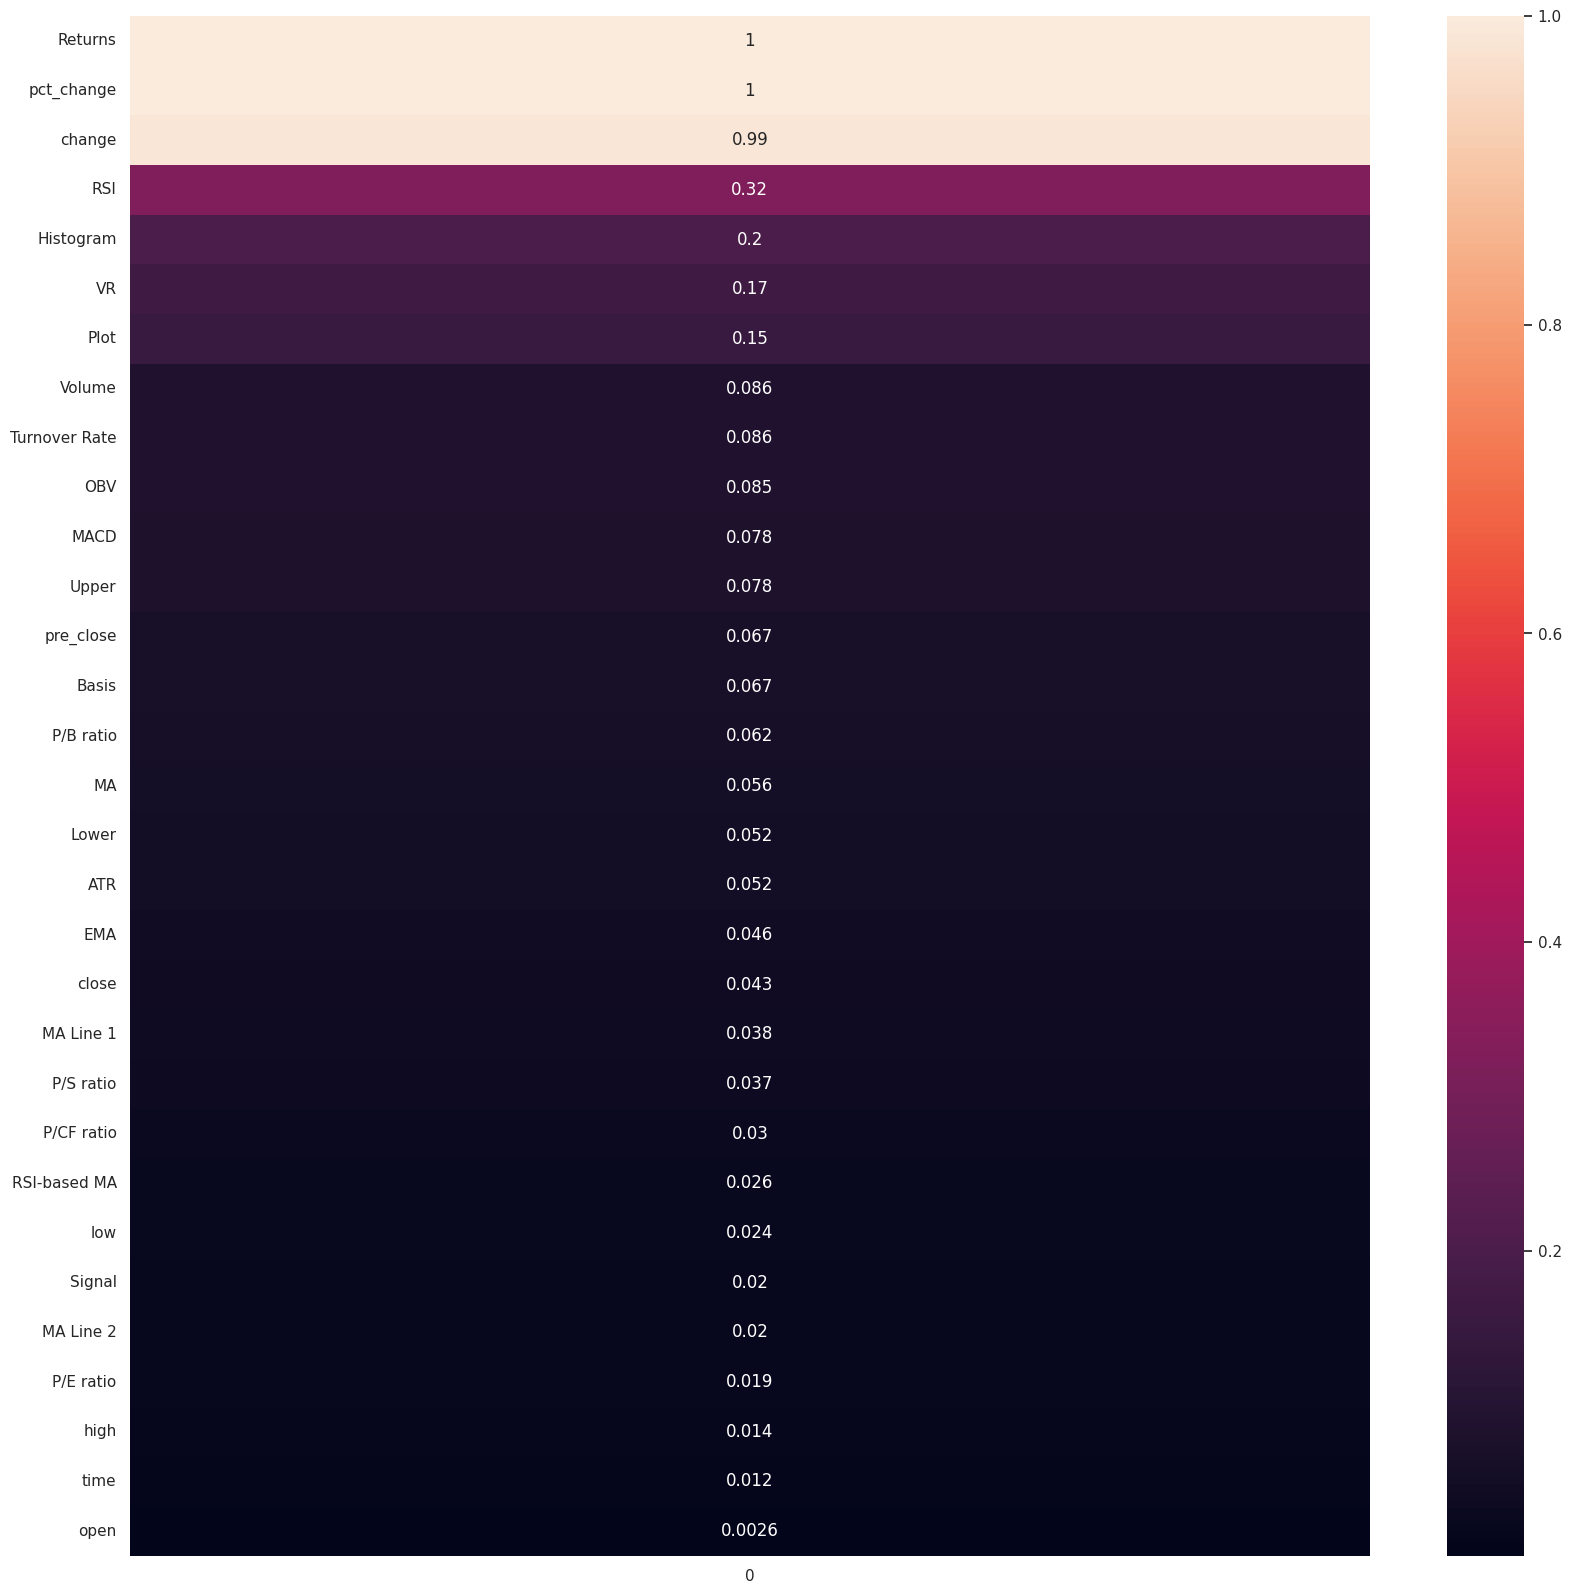

In [ ]:
Figure = plt.figure(figsize = (20,20))
Correlation = np.abs(Data.corr()["Returns"]).sort_values(ascending = False)
sns.heatmap(Correlation.values.reshape(-1,1), annot = True, yticklabels = Correlation.index)
plt.show()

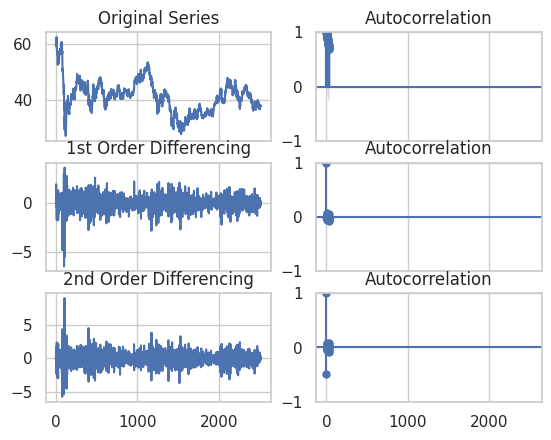

In [ ]:
#Determine the number of lags in the system
# Original Series
fig, axes = plt.subplots(3, 2, sharex=True)
axes[0, 0].plot(Data["close"].values); axes[0, 0].set_title('Original Series')
plot_acf(Data["close"].values, ax=axes[0, 1])
# 1st Differencing
axes[1, 0].plot(np.diff(Data["close"].values)); axes[1, 0].set_title('1st Order Differencing')
plot_acf(np.diff(Data["close"].values), ax=axes[1, 1])

# 2nd Differencing
axes[2, 0].plot(np.diff(np.diff(Data["close"].values))); axes[2, 0].set_title('2nd Order Differencing')
plot_acf(np.diff(np.diff(Data["close"].values)), ax=axes[2, 1])
plt.show()

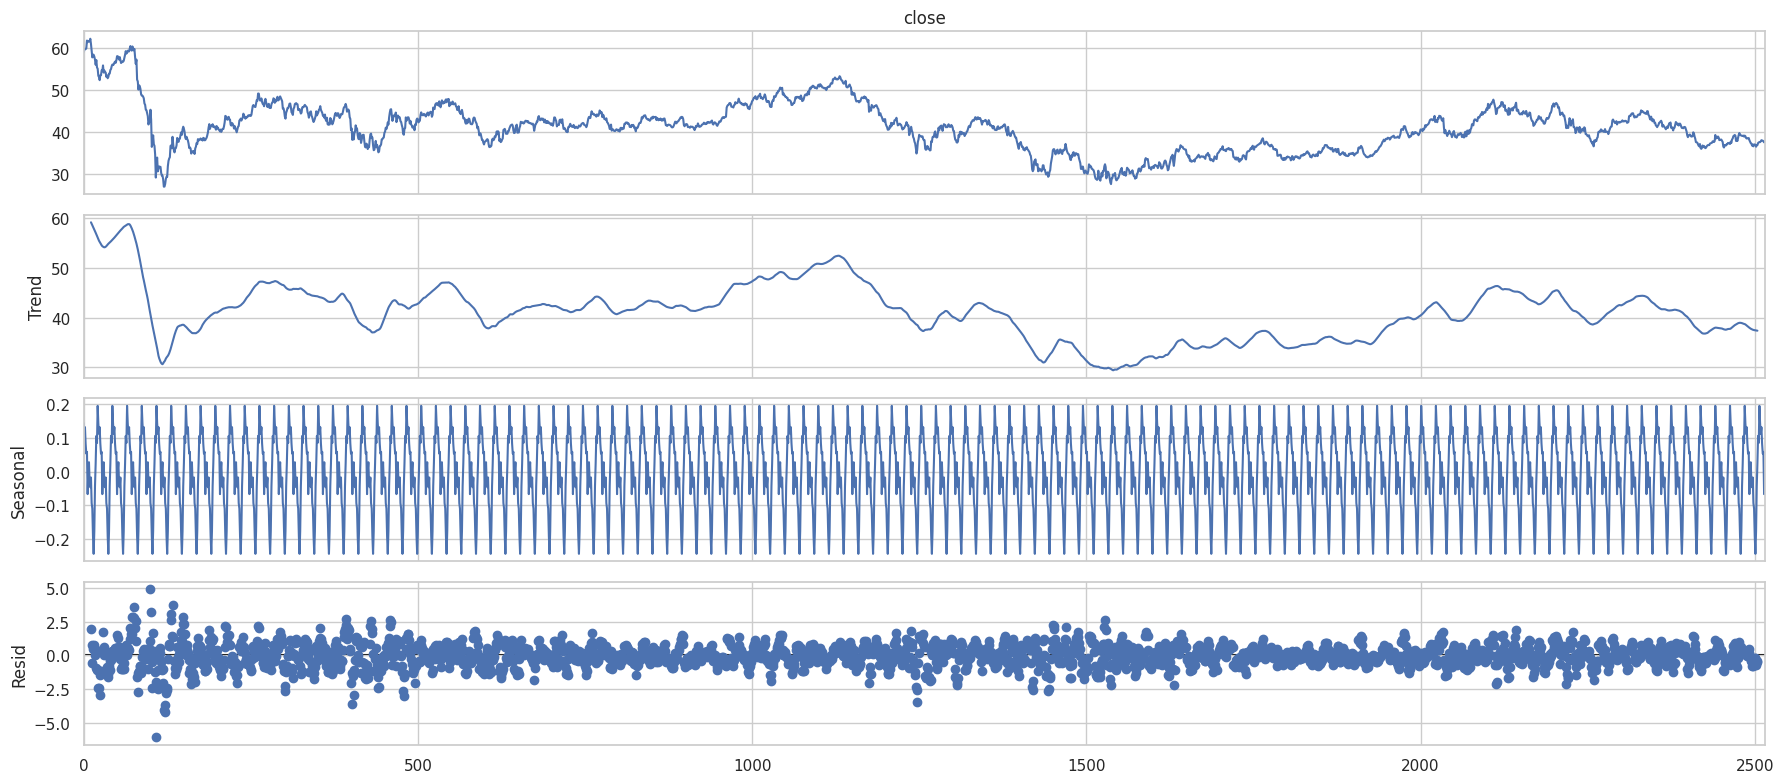

In [ ]:
# Plot the sesonal decomposition
import statsmodels.api as sm
from pylab import rcParams
rcParams['figure.figsize'] = 18, 8
decomposition = sm.tsa.seasonal_decompose(Data["close"].iloc[-10000:], model='additive', period = 22)
fig = decomposition.plot()
plt.tight_layout()
plt.show()

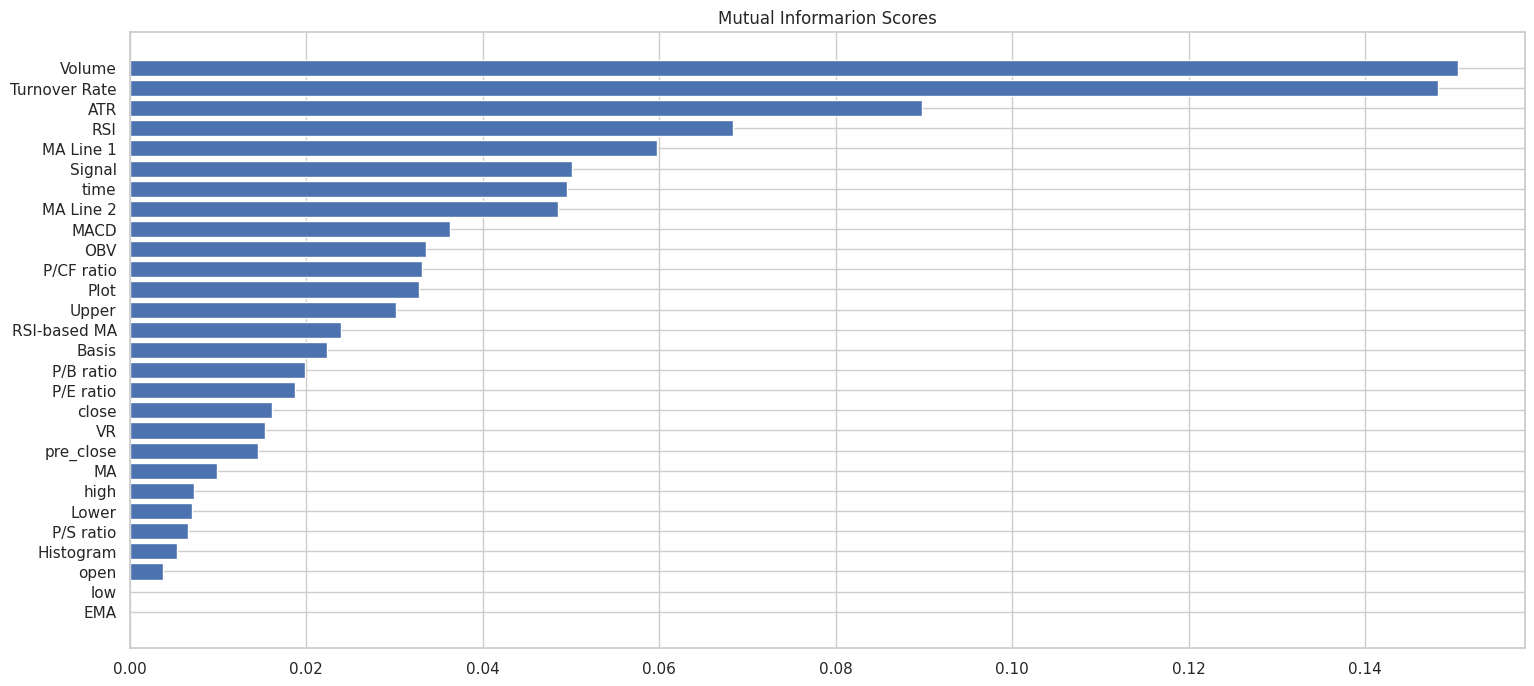

In [ ]:
Mi_Scores = make_mi_scores(Data.drop(columns = ["Returns", "pct_change", "change"]), Data["Returns"])
plot_mi_scores(Mi_Scores)

In [ ]:
from statsmodels.tsa.stattools import adfuller
dftest = adfuller(Data["close"], autolag = 'AIC')
print("1. ADF : ",dftest[0])
print("2. P-Value : ", dftest[1])
print("3. Num Of Lags : ", dftest[2])
print("4. Num Of Observations Used For ADF Regression and Critical Values Calculation :", dftest[3])
print("5. Critical Values :")
for key, val in dftest[4].items():
    print("\t",key, ": ", val)

1. ADF :  -4.232403801051538
2. P-Value :  0.0005804462197248652
3. Num Of Lags :  10
4. Num Of Observations Used For ADF Regression and Critical Values Calculation : 2505
5. Critical Values :
	 1% :  -3.4329631791044304
	 5% :  -2.8626944896608433
	 10% :  -2.5673845793841457


In [ ]:
def rolling_min_max_normalisation(series, window):
    return (series - series.rolling(window=window, min_periods=1).min()) / \
           (series.rolling(window=window, min_periods=1).max() - series.rolling(window=window, min_periods=1).min() + 1e-6)

def min_max_normalization(series, context=None):
    if context is not None:
        expanding_min = context[0]
        expanding_max = context[1] + 1e-6
    else:
        expanding_min = series.min()
        expanding_max = series.max() + 1e-6  # Adding small epsilon to avoid division by zero

    return (series - expanding_min) / (expanding_max - expanding_min), expanding_min, expanding_max

def rolling_z_score_scaler(series, window):
    rolling_mean = series.rolling(window=window, min_periods=1).mean()
    rolling_std = series.rolling(window=window, min_periods=1).std() + 1e-6
    return (series - rolling_mean) / rolling_std

def standard_z_score_norm(series, context = None):
    if context is not None:
        mean = context[0]
        std = context[1]
    else:
        mean = series.mean()
        std = series.std() + 1e-6

    return (series - mean)/(std), mean, std

In [ ]:
Data["close"].expanding(min_periods =1).min()[:1000]

,close
0,59.14999
1,59.14999
2,59.14999
3,59.14999
4,59.14999
...,...
995,27.02000
996,27.02000
997,27.02000
998,27.02000


In [ ]:
Data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2516 entries, 0 to 2515
Data columns (total 31 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   time           2516 non-null   float64
 1   open           2516 non-null   float64
 2   high           2516 non-null   float64
 3   low            2516 non-null   float64
 4   close          2516 non-null   float64
 5   pre_close      2516 non-null   float64
 6   change         2516 non-null   float64
 7   pct_change     2516 non-null   float64
 8   Volume         2516 non-null   float64
 9   Turnover Rate  2516 non-null   float64
 10  VR             2516 non-null   float64
 11  P/E ratio      2516 non-null   float64
 12  P/B ratio      2516 non-null   float64
 13  P/S ratio      2516 non-null   float64
 14  Basis          2516 non-null   float64
 15  Upper          2516 non-null   float64
 16  Lower          2516 non-null   float64
 17  EMA            2516 non-null   float64
 18  MA           

In [ ]:
def Feature_Engineering(file_name, sliding_window, validation_split, buffer):
    Data = pd.read_csv(file_name, parse_dates=['time']).dropna()

    # Extract the Dataset
    Data = Data[["time","open", "close", "high", "low", "Upper", "Lower", "Volume", "Turnover Rate", "ATR", "MA Line 1", "Signal", "MA Line 2", "MACD", "P/CF ratio", "EMA", "Basis", "Plot", "OBV"]]
    X,y = pd.DataFrame(), pd.DataFrame()

    Data["time"] = pd.to_datetime(Data["time"], format = "%d-%m-%Y")
    Data["weekday"] = Data["time"].dt.weekday
    Data["year"] = Data["time"].dt.year
    Data["month"] = Data["time"].dt.month
    Data["day"] = Data["time"].dt.day

    # Generate the Targets:
    y["returns"] = np.log(Data["close"] + 1e-6).diff().fillna(method = "bfill")
    y["close"] = Data['close']
    y["high"] = Data["high"]
    y["low"] = Data["low"]
    y["close"] = y["close"].fillna(method = "bfill")
    y["low"] = y["low"].fillna(method = "bfill")
    y["high"] = y["high"].fillna(method = "bfill")

    # Generate the Dates:
    X["weekday"] = Data["weekday"].fillna(method = "bfill")
    X["year"] = Data["year"].fillna(method = "bfill")
    X["month"] = Data["month"].fillna(method = "bfill")
    X["day"] = Data["day"].fillna(method = "bfill")

    # Generate the Original Features
    X["returns"] = y["returns"].fillna(method = "bfill")
    X["close"] = Data["close"].fillna(method = "bfill")
    X["open"] = Data["open"].fillna(method = "bfill")
    X["high"] = Data["high"].fillna(method = "bfill")
    X["low"] = Data["low"].fillna(method = "bfill")

    # Apply Some Feature Engineering:
    X[f"returns_{sliding_window}"] = y["returns"].rolling(sliding_window).mean().fillna(method = "bfill")
    X[f"returns_{sliding_window//2}"] = y["returns"].rolling(sliding_window//2).mean().fillna(method = "bfill")
    X[f"close_{sliding_window}"] = X["close"].rolling(24).mean().fillna(method = "bfill")
    X[f"close_{sliding_window}"] = X["close"].rolling(60).mean().fillna(method = "bfill")

    # Relative Returns Normalization
    X['open_rel'] = np.log(Data['open'] / Data['close'].shift(1))
    X['high_rel'] = np.log(Data['high'] / Data['close'].shift(1))
    X['low_rel'] = np.log(Data['low'] / Data['close'].shift(1))

    X[f"returns_{sliding_window-sliding_window//2}"] = X[f"returns_{sliding_window}"] -  X[f"returns_{sliding_window//2}"]
    X["Upper_Shadow"] = X["high"] - np.maximum(X["close"], X["open"])
    X["Lower_Shadow"] = X["low"] - np.minimum(X["close"], X["open"])

    X[f"Support_Level{sliding_window}"] = X["close"].rolling(sliding_window).min()
    X[f"Resistance_Level{sliding_window}"] = X["close"].rolling(sliding_window).max()

    X["upper_band"], X["middle_band"], X["lower_band"] = ta.BBANDS(X["close"])

    Decomposition = sm.tsa.seasonal_decompose(X["close"], model = "additive", period = sliding_window, two_sided = False)
    X["Trend"] = Decomposition.trend
    X["Seasonal"] = Decomposition.seasonal
    X["Residual"] = Decomposition.resid

    X["Volume"] = np.log(Data["Volume"] + 1e-6)
    X["Turnover Rate"] = np.log(Data["Turnover Rate"] + 1e-6)
    X["ATR"] = np.log(Data["ATR"] + 1e-6)
    X["MA Line 1"] = np.log(Data["MA Line 1"] + 1e-6)
    X["MA Line 2"] = np.log(Data["MA Line 2"] + 1e-6)
    X["Signal"] = Data["Signal"]
    X["MACD"] = Data["MACD"]
    X["P/CF ratio"] = Data["P/CF ratio"]
    X["Plot"] = Data["Plot"]
    X["OBV"] = np.log(Data["OBV"])
    X["EMA"] = Data["EMA"]
    X["Basis"] = Data["Basis"]
    X["Upper"] = Data["Upper"]
    X["Lower"] = Data["Lower"]

    X_Train, y_Train, X_Val, y_Val = X.iloc[:int(validation_split*len(X))], y.iloc[:int(validation_split*len(y))], X.iloc[int(validation_split*len(X)):], y.iloc[int(validation_split*len(y)):]

    Datetime_Features = ["weekday", "year", "month", "day"]
    X_Train_Normalised = X_Train.copy()
    X_Val_Normalised = X_Val.copy()

    X_Train_Normalised.iloc[:,4:], x_min, x_max = min_max_normalization(X_Train.iloc[:,4:])
    X_Val_Normalised.iloc[:,4:], _, _ = min_max_normalization(X_Val.iloc[:,4:], [x_min, x_max])

    buffer = sliding_window
    return X_Train_Normalised[buffer:], y_Train[buffer:], X_Val_Normalised[buffer:], y_Val[buffer:]# y_mean, y_std

In [ ]:
X_Train, y_Train, X_Val, y_Val  = Feature_Engineering('/content/stock_dataset.csv', 22, 0.8, 100)
X_Train.shape, y_Train.shape, X_Val.shape, y_Val.shape

((1990, 39), (1990, 4), (482, 39), (482, 4))

In [ ]:
X_Train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1990 entries, 22 to 2011
Data columns (total 39 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   weekday             1990 non-null   int32  
 1   year                1990 non-null   int32  
 2   month               1990 non-null   int32  
 3   day                 1990 non-null   int32  
 4   returns             1990 non-null   float64
 5   close               1990 non-null   float64
 6   open                1990 non-null   float64
 7   high                1990 non-null   float64
 8   low                 1990 non-null   float64
 9   returns_22          1990 non-null   float64
 10  returns_11          1990 non-null   float64
 11  close_22            1990 non-null   float64
 12  open_rel            1990 non-null   float64
 13  high_rel            1990 non-null   float64
 14  low_rel             1990 non-null   float64
 15  Upper_Shadow        1990 non-null   float64
 16  Lower_Shad

In [ ]:
y_Train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1990 entries, 22 to 2011
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   returns  1990 non-null   float64
 1   close    1990 non-null   float64
 2   high     1990 non-null   float64
 3   low      1990 non-null   float64
dtypes: float64(4)
memory usage: 77.7 KB


<Figure size 5000x5000 with 0 Axes>

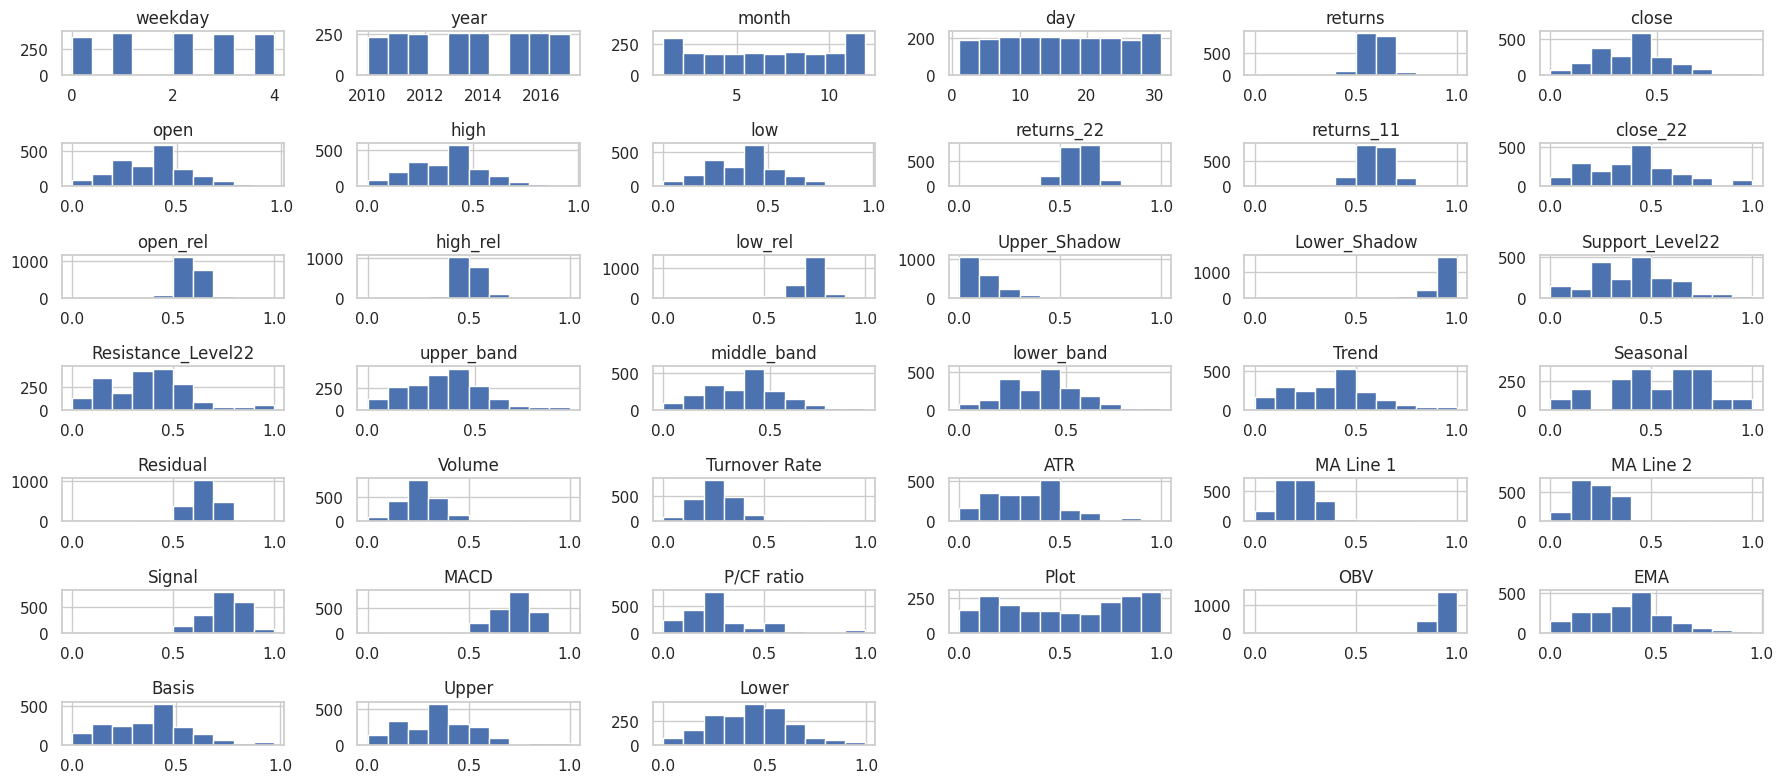

In [ ]:
Figure = plt.figure(figsize = (50,50))
X_Train.hist()
plt.tight_layout()
plt.show()

<Figure size 1000x1000 with 0 Axes>

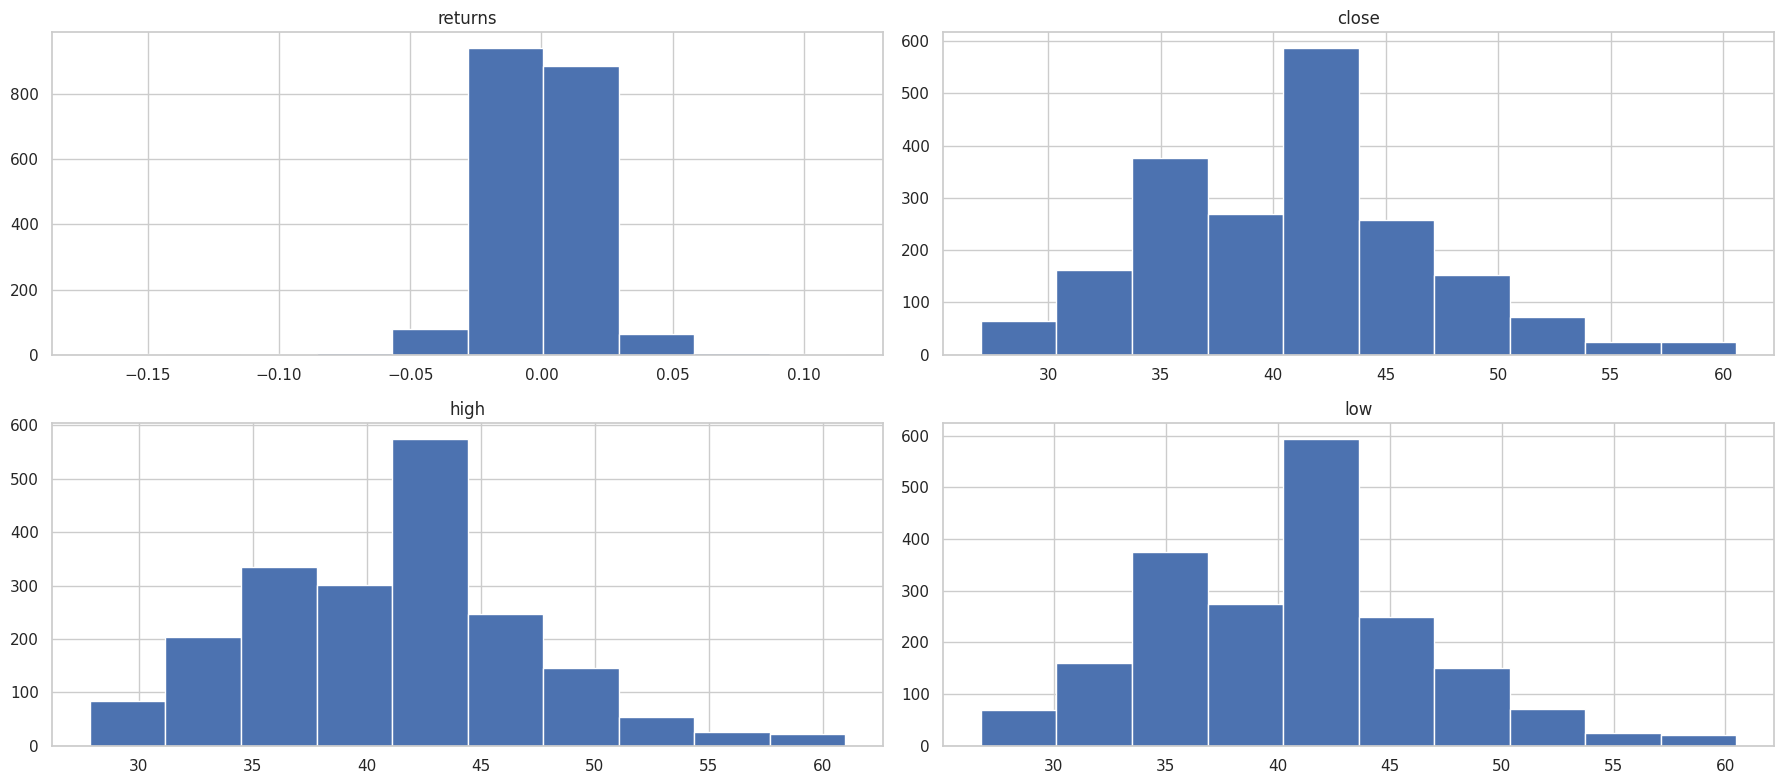

In [ ]:
Figure = plt.figure(figsize = (10,10))
y_Train.hist()
plt.tight_layout()
plt.show()

In [ ]:
def create_rolling_windows(data_X, data_y, window_size, prediction_horizon, n_steps):

    X,y = [], []
    data_values = data_X.values
    target_values = data_y.values
    print(data_X.shape, data_y.shape)
    print(len(data_X) - window_size - prediction_horizon - n_steps +1)
    for index in range(len(data_X) - window_size - prediction_horizon - n_steps +1):
        #print(index)
        window = data_values[index:index+window_size, :]
        X.append(window)

        target = target_values[index + window_size + prediction_horizon -1: index + window_size + prediction_horizon - 1 + n_steps, :]
        #print(target.shape)
        y.append(target)

    X = np.array(X)
    y = np.array(y)

    return X,y

In [ ]:
X_train_3d, y_train_3d = create_rolling_windows(X_Train, y_Train, 22, 1, 1)
X_train_3d.shape, y_train_3d.shape

(1990, 39) (1990, 4)
1967


((1967, 22, 39), (1967, 1, 4))

In [ ]:
X_valid_3d, y_valid_3d = create_rolling_windows(X_Val, y_Val, 22, 1, 1)
X_valid_3d.shape, y_valid_3d.shape

(482, 39) (482, 4)
459


((459, 22, 39), (459, 1, 4))

In [ ]:
X_train_tensor = torch.tensor(X_train_3d, dtype = torch.float32)
y_train_tensor = torch.tensor(y_train_3d, dtype = torch.float32)
y_train_tensor = y_train_tensor.squeeze(1)
X_valid_tensor = torch.tensor(X_valid_3d, dtype = torch.float32)
y_valid_tensor = torch.tensor(y_valid_3d, dtype = torch.float32)
y_valid_tensor = y_valid_tensor.squeeze(1)

In [ ]:
class TimeSeriesDataset(torch.utils.data.Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        #print(self.X.shape)
        return self.X[idx, :, 4:], self.y[idx], idx

    def __getdate__(self, idx):
        return self.X[idx, :, :4]

Train_Dataset = TimeSeriesDataset(X_train_tensor, y_train_tensor)
Valid_Dataset = TimeSeriesDataset(X_valid_tensor, y_valid_tensor)

Train_Loader = torch.utils.data.DataLoader(Train_Dataset, batch_size = 32, shuffle = True)
Validation_Loader = torch.utils.data.DataLoader(Valid_Dataset, batch_size = 32, shuffle = False)

len(Train_Loader), len(Validation_Loader)

(62, 15)

In [ ]:
Train_Dataset.__getitem__(0)[0].shape

torch.Size([22, 35])

In [ ]:
def mean_absolute_percentage_error(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

def calculate_metrics(y_true, y_pred):
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    mape = mean_absolute_percentage_error(y_true, y_pred)
    return mse, rmse, mae, r2, mape

In [ ]:
import torch
import torch.nn as nn
import pytorch_lightning as pL
import torch.optim as optim
import torch.nn.functional as F

class LSTMModel(pL.LightningModule):
    def __init__(self, input_size, hidden_size, output_size, learning_rate = 1e-3, weight_decay = 1e-4):
        super(LSTMModel, self).__init__()
        self.hidden_size = hidden_size
        self.layer_norm = nn.LayerNorm(input_size)
        self.lstm = nn.LSTM(input_size, hidden_size, dropout = 0.2, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)
        self.learning_rate = learning_rate
        self.weight_decay = weight_decay
        self.save_hyperparameters()
        self.reset_parameters()

    def forward(self, x):
        h0 = torch.zeros(1, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(1, x.size(0), self.hidden_size).to(x.device)
        x = self.layer_norm(x)
        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])
        return out

    def predict(self, x):
        return self.forward(x)

    def training_step(self, batch, batch_idx = None):
        X,y, _ = batch
        predicted = self.forward(X)
        train_loss = F.mse_loss(predicted, y)
        learning_rate = self.trainer.optimizers[0].param_groups[0]['lr']
        self.log("learning_rate", learning_rate, on_step = False, on_epoch = True, prog_bar = True, logger = True)
        self.log("train_loss", train_loss, on_step = False, on_epoch = True, prog_bar = True, logger = True)
        return train_loss

    def validation_step(self, batch, batch_idx = None):
        X,y, _= batch
        predicted = self.forward(X)
        valid_loss = F.mse_loss(predicted, y)
        self.log("valid_loss", valid_loss, on_step = False, on_epoch = True, prog_bar = True, logger = True)
        return valid_loss

    def test_step(self, batch, batch_idx = None):
        X,y, _ = batch
        predicted = self.forward(X)
        test_loss = F.mse_loss(predicted, y)
        self.log("test_loss", test_loss, on_step = False, on_epoch = True, prog_bar = True, logger = True)
        return test_loss

    def weight_init(self,m):
        if isinstance(m, nn.LSTM):
            for name, param in m.named_parameters():
                if 'weight_ih' in name:  # Input to hidden weights
                    nn.init.xavier_uniform_(param.data)  # Xavier initialization
                elif 'weight_hh' in name:  # Hidden to hidden weights
                    nn.init.orthogonal_(param.data)  # Orthogonal initialization for recurrent connections
                elif 'bias' in name:
                    param.data.fill_(0)  # Initialize biases to zero
                    # Optional: Setting forget gate bias to 1 (can improve convergence)
                    # LSTM biases are typically structured as [bias_ig, bias_fg, bias_og, bias_cg]
                    # Set forget gate bias (bias_fg) to 1
                    n = param.size(0)
                    param.data[n // 4: n // 2].fill_(1.0)

        if isinstance(m, nn.Linear):
            nn.init.xavier_uniform_(m.weight)
            if m.bias is not None:
                nn.init.zeros_(m.bias)

    def reset_parameters(self):
        for _, m in enumerate(self.modules()):
            if not isinstance(m, nn.LazyLinear):
                self.weight_init(m)

    def configure_optimizers(self):
        optimizer = optim.AdamW(self.parameters(), lr = self.learning_rate, weight_decay = self.weight_decay)
        Scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', factor=0.7, patience=5, verbose=True, min_lr=1e-8)

        Scheduler = {
            'scheduler': Scheduler,
            'monitor': 'valid_loss',
            'interval': 'epoch',
            'frequency': 1,
            'strict': True
        }
        return [optimizer], [Scheduler]

# Parameters
input_size = 35  # Number of features (columns A, B, C, D, E)
hidden_size = 64
output_size = 4  # Predict columns C, D, E

# Instantiate model
model = LSTMModel(input_size, hidden_size, output_size)

In [ ]:
import torch
print(torch.cuda.is_available())

True


In [ ]:
from pytorch_lightning.callbacks import ModelCheckpoint, EarlyStopping, LearningRateMonitor
checkpoint_callback = ModelCheckpoint(monitor = "valid_loss", save_top_k = 1, mode = "min", filename = "BestCheckpoint", save_weights_only = True)
# Trains the model using the Pytorch Lightning Trainer
Trainer = pL.Trainer(gradient_clip_val=1.0,
                     accelerator= "gpu", devices = [0],
                     max_epochs=100,
                     callbacks=[LearningRateMonitor("epoch"),
                                EarlyStopping('valid_loss', patience=20, mode = "min"),
                                checkpoint_callback],
                    )
Trainer.fit(model, Train_Loader, Validation_Loader)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name       | Type      | Params | Mode 
-------------------------------------------------
0 | layer_norm | LayerNorm | 70     | train
1 | lstm       | LSTM      | 25.9 K | train
2 | fc         | Linear    | 260    | train
-------------------------------------------------
26.2 K    Trainable params
0         Non-trainable params
26.2 K    Total params
0.105     Total estimated model params size (MB)
3         Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

In [ ]:

replace = False
if os.path.exists('/content/checkpoints/LSTM_BestCheckpoint.ckpt') and replace == True:
    best_model_path = '/content/checkpoints/LSTM_BestCheckpoint.ckpt'
else:
  print("New Checkpoint Generated")
  best_model_path = checkpoint_callback.best_model_path  # This gives the path of the best checkpoint saved
print(f"Best model saved at: {best_model_path}")

# Load the model weights into a new instance
# Assuming these are the arguments you used when initializing the model
best_model = LSTMModel.load_from_checkpoint(
    checkpoint_path=best_model_path,

)
if not replace:
  files.download(best_model_path)


New Checkpoint Generated
Best model saved at: /content/lightning_logs/version_4/checkpoints/BestCheckpoint.ckpt


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
Trainer.test(best_model, Train_Loader)

INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_loss         │    0.29225286841392517    │
└───────────────────────────┴───────────────────────────┘

[{'test_loss': 0.29225286841392517}]

In [ ]:
Trainer.test(best_model, Validation_Loader)

INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_loss         │    0.3355787396430969     │
└───────────────────────────┴───────────────────────────┘

[{'test_loss': 0.3355787396430969}]

In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import torch.nn.functional as F
from datetime import datetime, timedelta

best_model.eval()
n_steps = 1
device = "cuda"
best_model = best_model.to(device)

predicted_values = np.array([])
target_values = np.array([])
Datetime_Object = []

with torch.no_grad():
    for batch_idx, element in enumerate(Validation_Loader):
        X, y, indices = element  # Now retrieve the indices from the DataLoader
        X = X.to(device)
        y = y.to(device)

        # Predict using the model
        predicted = best_model(X).detach().cpu()
        mse_loss = F.mse_loss(predicted, y.cpu(), reduction="mean")

        # Print shapes for debugging
        #print(X.shape)
        #print(predicted.shape)
        #print(y.shape)

        # Fetch the datetime information using the correct indices
        date_batch = Valid_Dataset.__getdate__(indices).detach().cpu().numpy()
        Dates = []
        for date in range(len(date_batch)):
          #print(date, int(date_batch[date, -1, 2]))
          Date_Time = datetime(int(date_batch[date, -1, 1]), int(date_batch[date, -1, 2]), int(date_batch[date, -1, 3]))
          Dates.append(Date_Time + timedelta(days=n_steps))

        if batch_idx == 0:
            predicted_values = predicted.numpy()
            target_values = y.cpu().numpy()
            Datetime_Object = Dates
        else:
            predicted_values = np.concatenate([predicted_values, predicted.numpy()], axis=0)
            target_values = np.concatenate([target_values, y.cpu().numpy()], axis=0)
            Datetime_Object = np.concatenate([Datetime_Object, Dates], axis=0)

# Continue with your evaluation metrics, e.g., mean_squared_error, etc.
predicted_values = np.array(predicted_values)
Datetime_Object = np.array(Datetime_Object)
predicted_values, target_values,

(array([[-1.7488910e-02,  3.9749527e+01,  4.0083817e+01,  3.9360073e+01],
        [-1.2311472e-02,  3.9840668e+01,  4.0204067e+01,  3.9482239e+01],
        [-1.8458230e-02,  3.8866261e+01,  3.9325699e+01,  3.8480473e+01],
        ...,
        [-4.4026386e-02,  3.7487392e+01,  3.7874420e+01,  3.7330551e+01],
        [-4.0822688e-02,  3.7493408e+01,  3.7857826e+01,  3.7327084e+01],
        [-4.5562647e-02,  3.7607079e+01,  3.7886497e+01,  3.7413879e+01]],
       dtype=float32),
 array([[ 9.9098766e-03,  3.9549999e+01,  3.9799999e+01,  3.9365002e+01],
        [-6.0867546e-03,  3.9310001e+01,  3.9599998e+01,  3.9049999e+01],
        [ 3.8085610e-03,  3.9459999e+01,  3.9525002e+01,  3.9230000e+01],
        ...,
        [-1.5785323e-03,  3.7980000e+01,  3.8200001e+01,  3.7939999e+01],
        [-3.1645596e-03,  3.7860001e+01,  3.8250000e+01,  3.7860001e+01],
        [-6.8910951e-03,  3.7599998e+01,  3.7967999e+01,  3.7570000e+01]],
       dtype=float32))

In [ ]:
Dataset = pd.concat([pd.DataFrame(Datetime_Object, columns = ["DateTime"]), pd.DataFrame(predicted_values, columns = ["returns", "close", "high", "low"]), pd.DataFrame(target_values, columns = ["target_returns", "target_close", "target_high", "target_low"])], axis = 1)
Dataset

,DateTime,returns,close,high,low,target_returns,target_close,target_high,target_low
0,2018-03-06,-0.017489,39.749527,40.083817,39.360073,0.009910,39.549999,39.799999,39.365002
1,2018-03-07,-0.012311,39.840668,40.204067,39.482239,-0.006087,39.310001,39.599998,39.049999
2,2018-03-08,-0.018458,38.866261,39.325699,38.480473,0.003809,39.459999,39.525002,39.230000
3,2018-03-09,-0.008029,39.514240,40.134544,39.272526,0.005056,39.660000,39.814999,39.570000
4,2018-03-10,-0.003746,39.811867,40.421730,39.575489,0.004779,39.849998,39.880001,39.580002
...,...,...,...,...,...,...,...,...,...
454,2019-12-21,-0.033123,37.246727,37.410065,36.933327,0.006846,38.110001,38.119999,37.709999
455,2019-12-24,-0.037510,37.356956,37.565746,37.071877,-0.001838,38.040001,38.139999,37.959999
456,2019-12-25,-0.044026,37.487392,37.874420,37.330551,-0.001579,37.980000,38.200001,37.939999
457,2019-12-27,-0.040823,37.493408,37.857826,37.327084,-0.003165,37.860001,38.250000,37.860001


In [ ]:
Save_Dataset = Dataset[["close", "returns"]]
Save_Dataset.to_csv("LSTM_Predictions.csv")

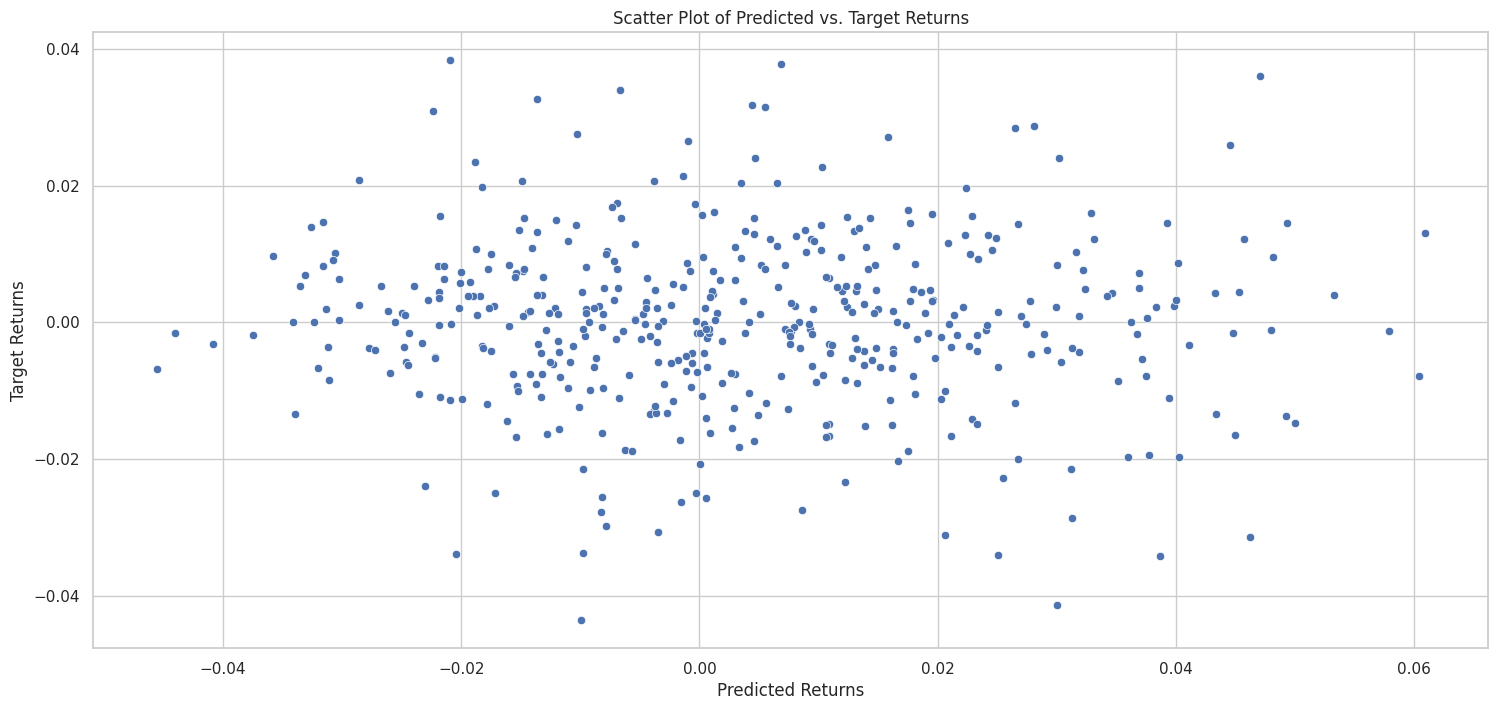

In [ ]:
sns.scatterplot(x = predicted_values[:,0], y = target_values[:,0])
plt.xlabel("Predicted Returns")
plt.ylabel("Target Returns")
plt.title("Scatter Plot of Predicted vs. Target Returns")
plt.show()

Text(0.5, 1.0, 'Cumulative Returns over Time')

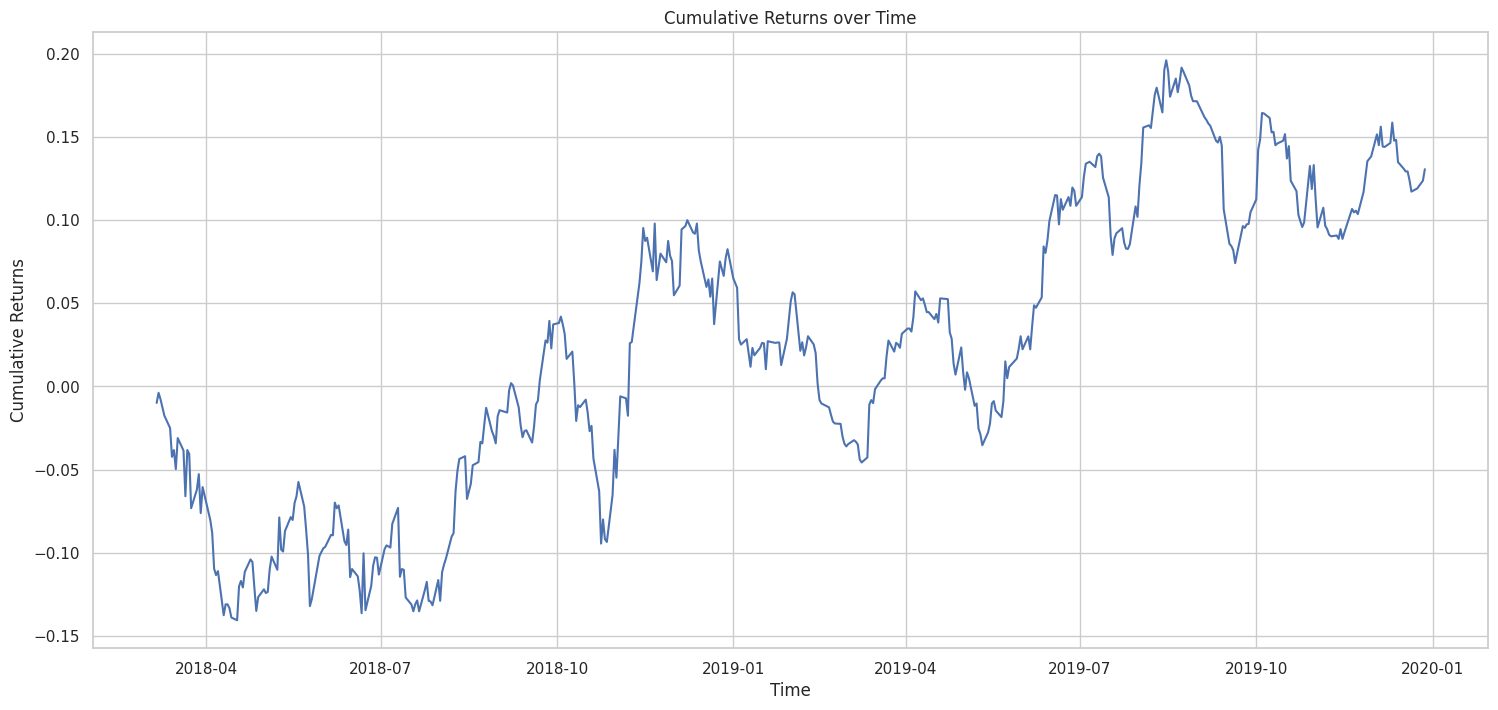

In [ ]:
Returns = pd.Series(np.cumsum(np.sign(predicted_values[:,0]) * target_values[:,0]))
sns.lineplot(x = Dataset.DateTime, y = Returns)
plt.xlabel("Time")
plt.ylabel("Cumulative Returns")
plt.title("Cumulative Returns over Time")

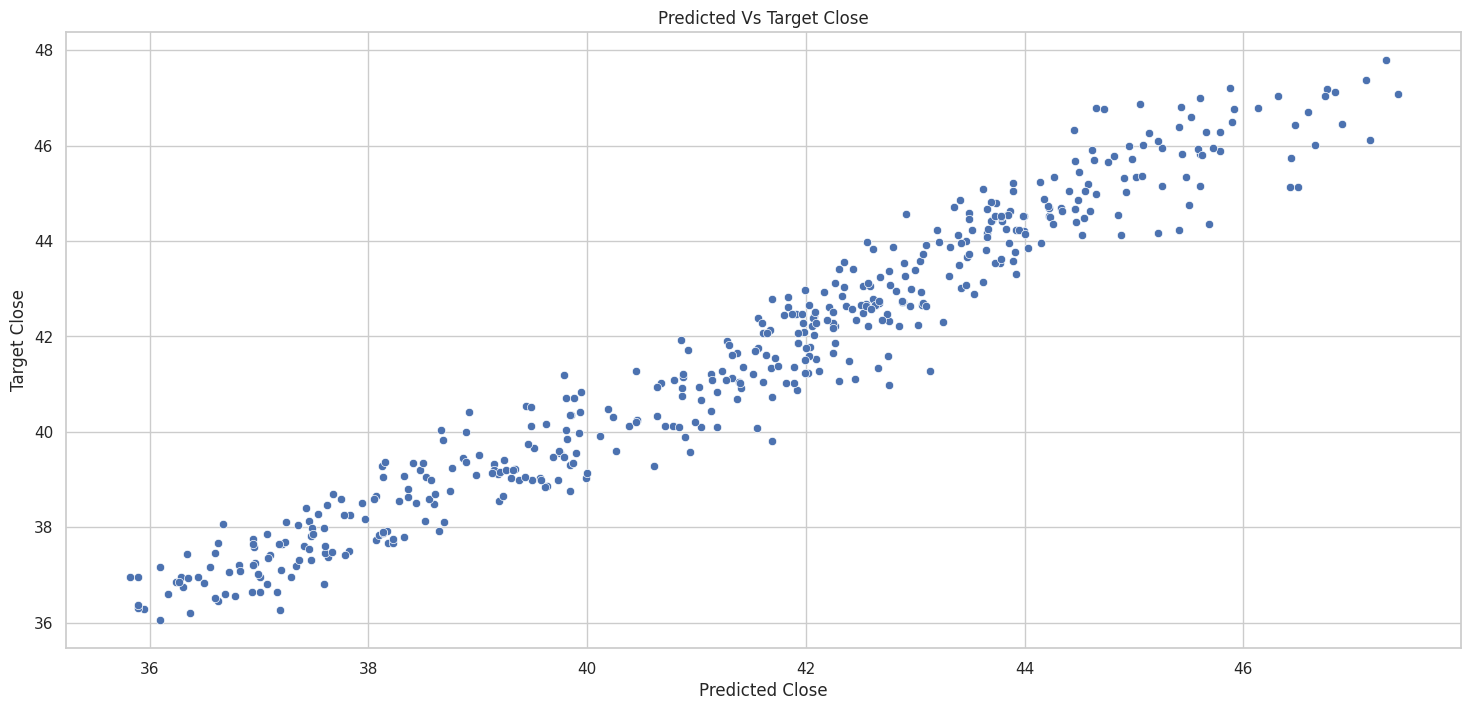

In [ ]:
sns.scatterplot(x = predicted_values[:,1], y = target_values[:,1])
plt.xlabel("Predicted Close")
plt.ylabel("Target Close")
plt.title("Predicted Vs Target Close")
plt.show()

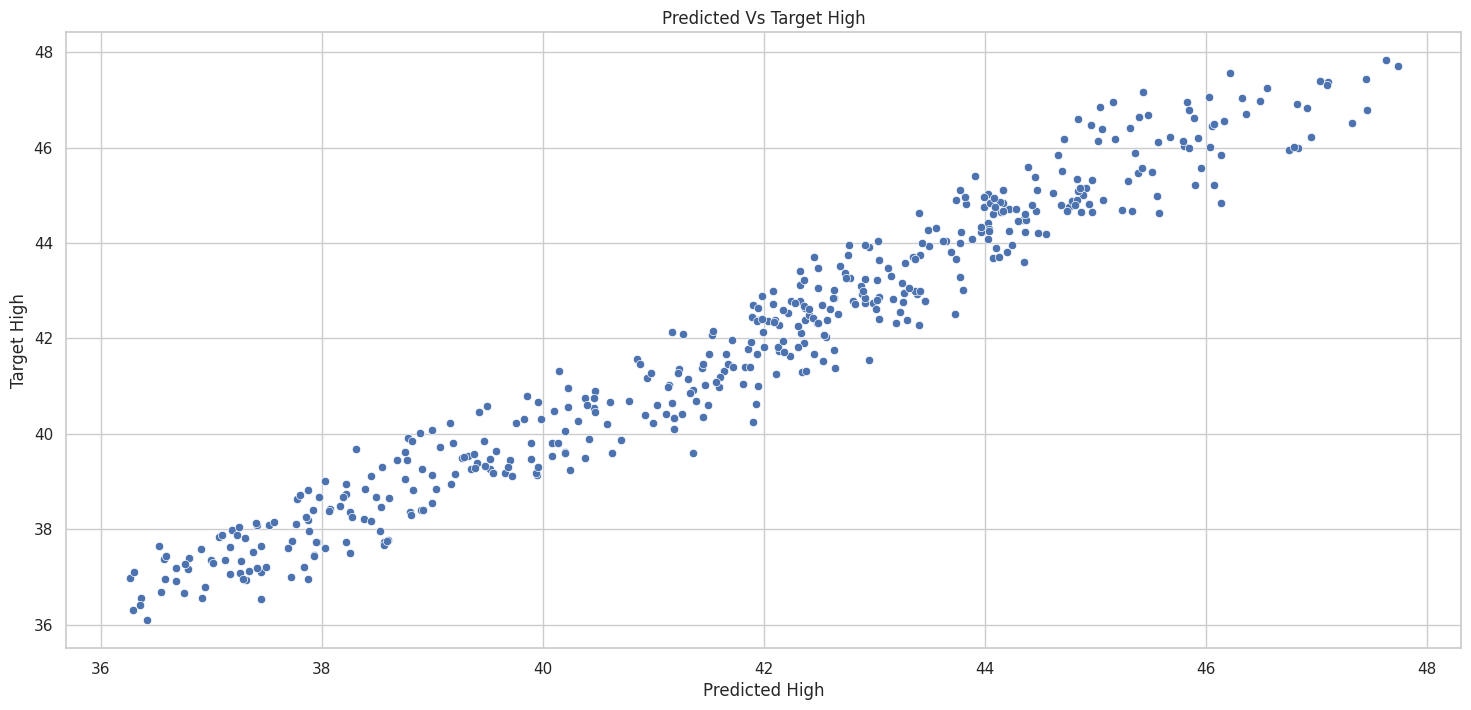

In [ ]:
sns.scatterplot(x = predicted_values[:,2], y = target_values[:,2])
plt.xlabel("Predicted High")
plt.ylabel("Target High")
plt.title("Predicted Vs Target High")
plt.show()

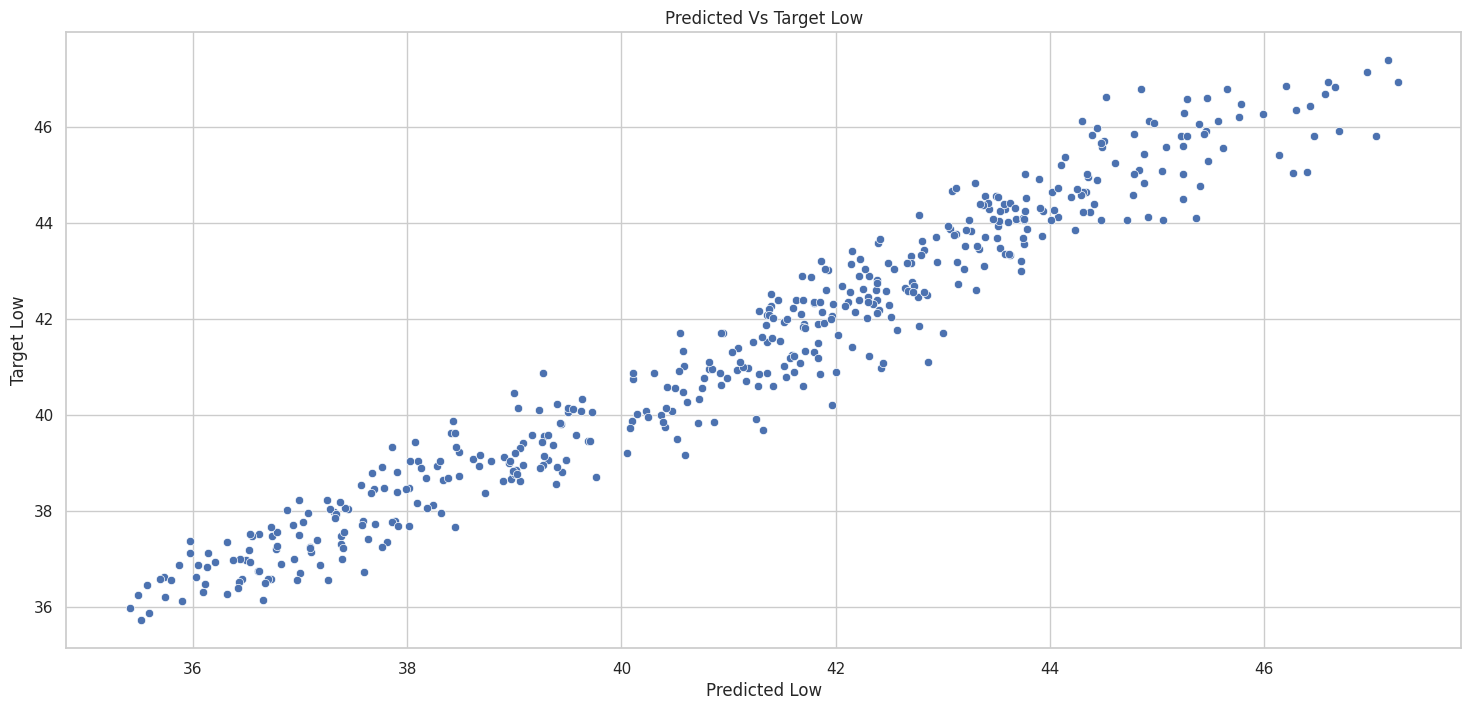

In [ ]:
sns.scatterplot(x = predicted_values[:,3], y = target_values[:,3])
plt.xlabel("Predicted Low")
plt.ylabel("Target Low")
plt.title("Predicted Vs Target Low")
plt.show()

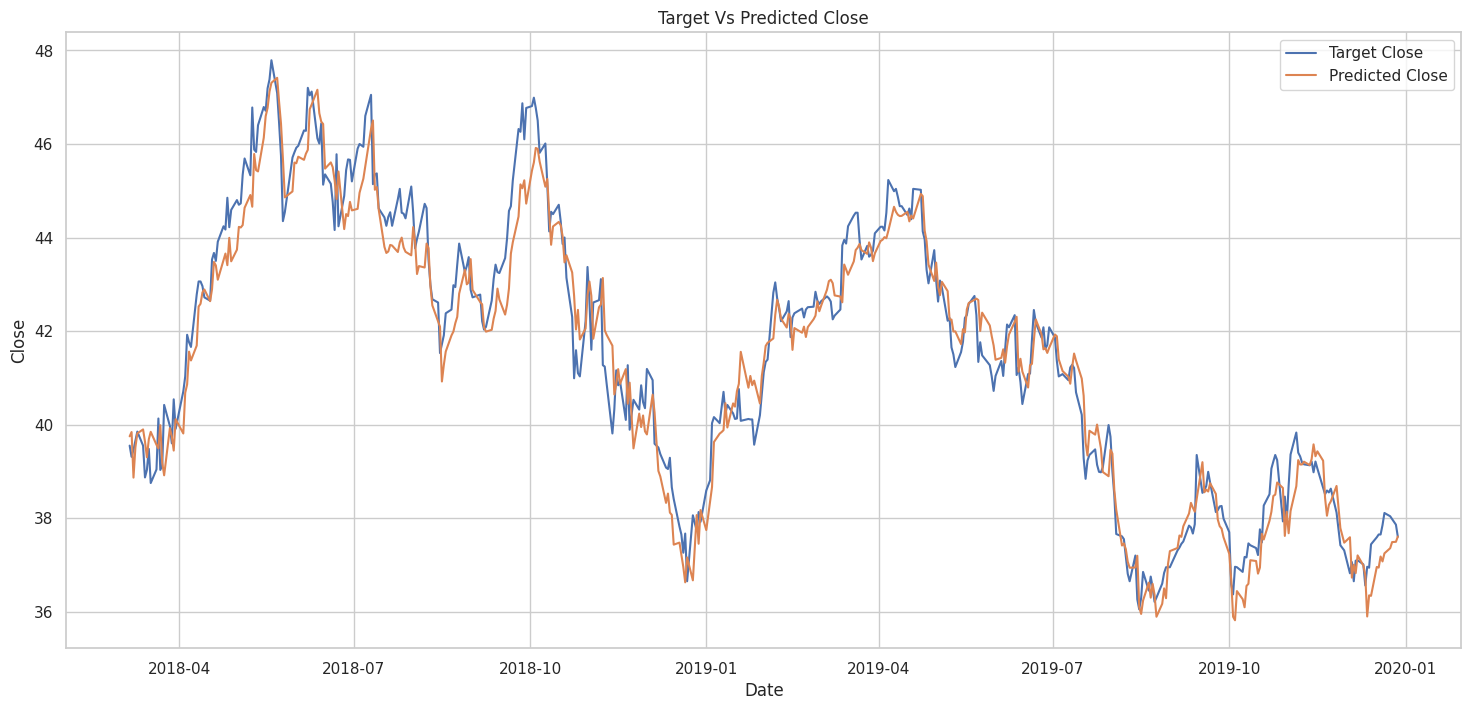

In [ ]:
sns.lineplot(x = Dataset.DateTime, y = target_values[:,1], label = "Target Close")
sns.lineplot(x = Dataset.DateTime, y = predicted_values[:,1], label = "Predicted Close")

plt.xlabel('Date')
plt.ylabel('Close')
plt.title('Target Vs Predicted Close')

plt.legend()  # Add legend based on labels
plt.show()

In [ ]:
print(calculate_metrics(predicted_values[:,1] , target_values[:,1]))
print(calculate_metrics(np.roll(target_values[:,1],1), target_values[:,1]))

(0.4618852, 0.6796214, 0.54728997, 0.9430052333854511, 1.3201204128563404)
(0.27679777, 0.5261157, 0.38775596, 0.9678136331709032, 0.932573713362217)


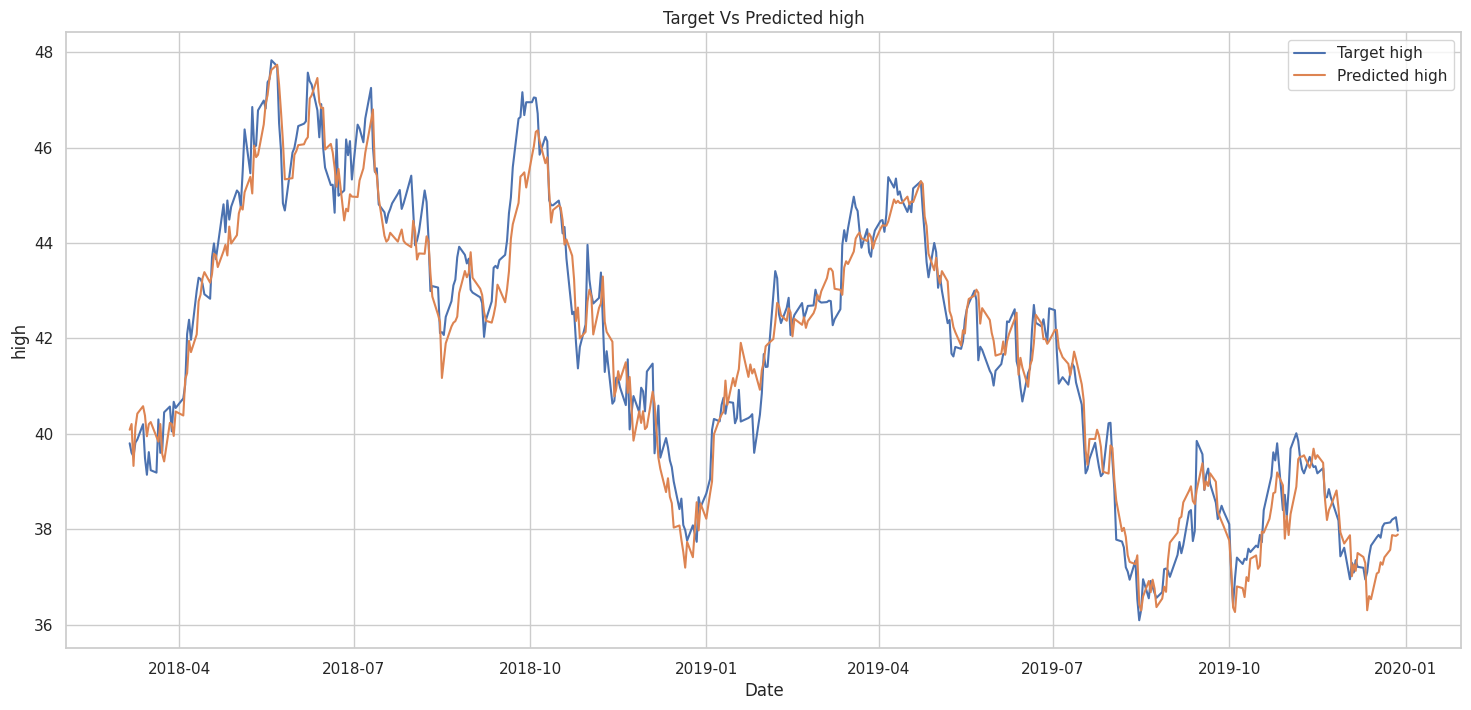

In [ ]:
sns.lineplot(x = Dataset.DateTime, y = target_values[:,2], label = "Target high")
sns.lineplot(x = Dataset.DateTime, y = predicted_values[:,2], label = "Predicted high")

plt.xlabel('Date')
plt.ylabel('high')
plt.title('Target Vs Predicted high')

plt.legend()  # Add legend based on labels
plt.show()

In [ ]:
print(calculate_metrics(predicted_values[:,2] , target_values[:,2]))
print(calculate_metrics(np.roll(target_values[:,2],1), target_values[:,2]))

(0.40396935, 0.63558584, 0.5160768, 0.949943418928857, 1.237285416573286)
(0.2676536, 0.5173525, 0.3846096, 0.9689221661731069, 0.9184007532894611)


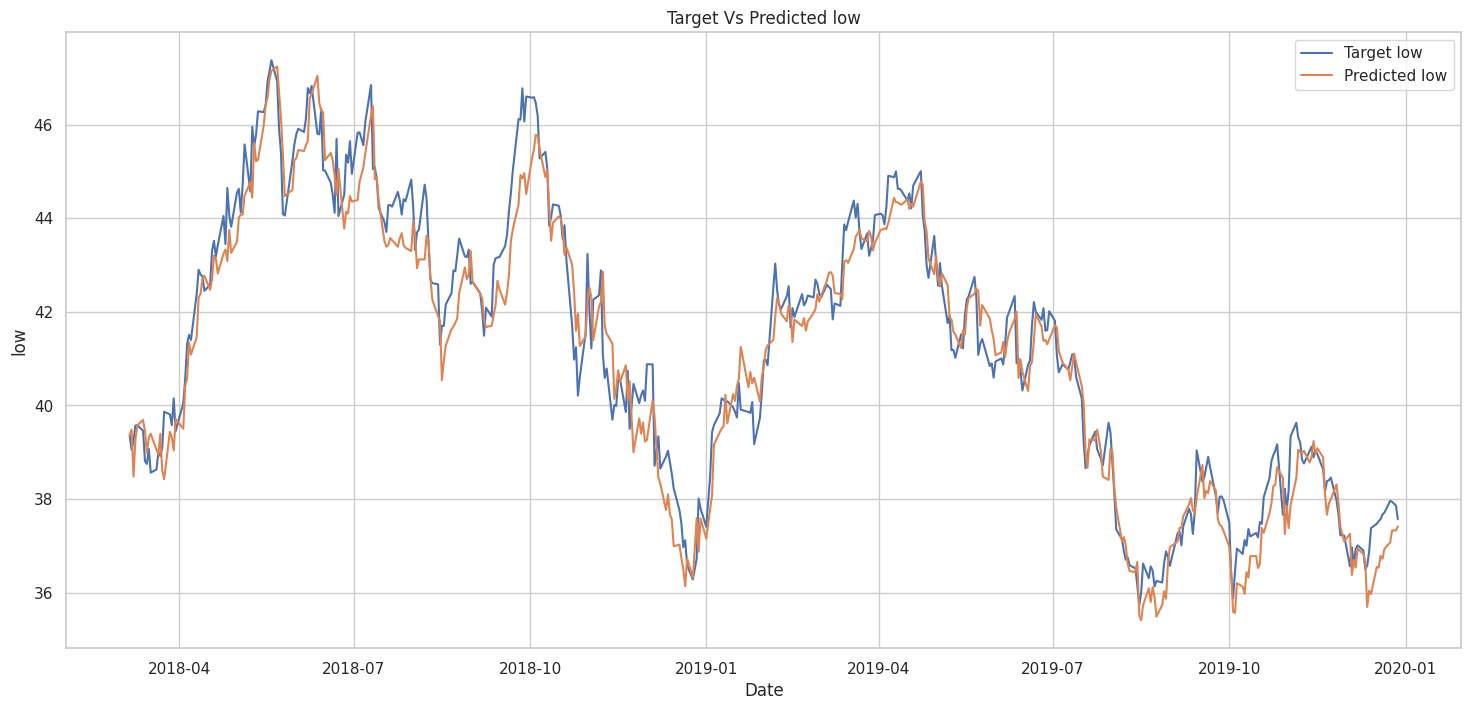

In [ ]:
sns.lineplot(x = Dataset.DateTime, y = target_values[:,3], label = "Target low")
sns.lineplot(x = Dataset.DateTime, y = predicted_values[:,3], label = "Predicted low")

plt.xlabel('Date')
plt.ylabel('low')
plt.title('Target Vs Predicted low')

plt.legend()  # Add legend based on labels
plt.show()

In [ ]:
print(calculate_metrics(predicted_values[:,3] , target_values[:,3]))
print(calculate_metrics(np.roll(target_values[:,3],1), target_values[:,3]))

(0.47586998, 0.6898333, 0.5586452, 0.9436517836846269, 1.3627123087644577)
(0.29400748, 0.5422246, 0.40413457, 0.9655902883462206, 0.9759398177266121)
